In [1]:
! pip install --upgrade seaborn

     |████████████████████████████████| 283 kB 10.4 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import data_utils
import pred_utils
import models

import numpy as np
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set()
rcParams['font.family'] = 'DejaVu Serif'

from collections import Counter
import music21 as mc

models.set_seed(13111996)

SEED: 13111996
python 3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
keras version 2.4.0
tensorflow version 2.3.0
SEED: 13111996
python 3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
keras version 2.4.0
tensorflow version 2.3.0


### Methods

In [2]:
def _to_pitch(note, with_octave=False):
    if any(word in note for word in ["REST", "UNK"]):
        return -1.0
    else:
        if with_octave or not note[-1].isdigit():
            return mc.note.Note(note.split('_')[0]).pitch.ps 
        else:
            return mc.note.Note(note.split('_')[0][:-1]).pitch.ps 
        
def _get_intervals(notes_list, translate=False):
    all_intervals = []
    for notes in notes_list:
        intervals = []
        prev_pitch = None
        for note in notes:
            first = note.split('_')[0]
            if translate:
                nt = _to_pitch(first, with_octave=True)
            else:
                try:
                    nt = float(first)
                except ValueError:
                    translate = True
                    nt = _to_pitch(first, with_octave=True)
            if nt != -1.0:
                next_pitch = nt
                if prev_pitch:
                    intervals.append(next_pitch-prev_pitch)
                prev_pitch = next_pitch
        all_intervals.append(intervals)
    return all_intervals
        
def plot_pitches_intervals(ax, notes_list, artist=None, title=False, multi=False):
    all_intervals = _get_intervals(notes_list)

    bs = [-20, *[i for i in range(-18, 20, 2)], 20]
    if not multi:
        sns.distplot(
            [ival for intervals in all_intervals for ival in intervals],
            kde=False, 
            bins=bs, 
            hist=True,
            color="g", 
            hist_kws=dict(alpha=0.9),
            ax=ax
        )
    else:
        sns.distplot(
            [ival for intervals in all_intervals for ival in intervals],
            kde=False, 
            bins=bs, 
            hist=True,
            hist_kws=dict(alpha=0.9),
            ax=ax
        )
    # plt.xlim((-20, 20))
    _ = ax.set_xticks(bs[::2])
    if title:
        if artist:
            ax.set_title(f"Distribution of intervals\n(clipped to range -20.0 and 20.0)\nArtist: {artist.upper()}")
        else:
            ax.set_title(f"Distribution of intervals\n(clipped to range -20.0 and 20.0)")

def plot_pitches_distribution(ax, notes, all_notes=None, with_octave=True, text=False):
    notes_counts = Counter(notes).most_common()
    if all_notes:
        for n in all_notes:
            if n not in notes:
                notes_counts.append((n, 0))
            
    notes_counts_sorted = sorted(notes_counts, key=lambda x : _to_pitch(x[0], with_octave=with_octave))

    colors = []
    for note, _ in notes_counts_sorted:
        if note == "REST" or note == 'UNK':
            colors.append("springgreen")
        elif "#" in note or "-" in note:
            colors.append("violet")
        else:
            colors.append("g")

    chart = sns.barplot(x=[n[0] for n in notes_counts_sorted], y=[n[1] for n in notes_counts_sorted], palette=colors, ax=ax)
    _ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='center')
    
    if text:
        for idx, (note, count) in enumerate(notes_counts_sorted):
            if "#" not in note and "-" not in note and "4" in note:
                chart.text(idx, count, note, color='black', ha="center")
            if "REST" in note:
                chart.text(idx, count, "R", color='black', ha="center")
            
def read_predictions(predictions_dir, which=None):
    pred_notes = []
    ids = []
    for filename in sorted(
        [fnam for fnam in os.listdir(predictions_dir) if fnam.endswith('json')], 
        key = lambda x : int(x.split('_')[0])
    ):
        if not which:
            if ('train' in filename or 'val' in filename) and filename.endswith('.json'):
                with open(os.path.join(predictions_dir, filename), "r") as handle:
                    content = json.load(handle)
                    pred_notes.append(content['melody'])
                    ids.append(filename.split('.')[0])
        else:
            if which in filename and filename.endswith('.json'):
                with open(os.path.join(predictions_dir, filename), "r") as handle:
                    content = json.load(handle)
                    pred_notes.append(content['melody'])
                    ids.append(filename.split('.')[0])
    
    return pred_notes, ids

#     ax.set_title("Distribution of notes")
    
def _get_duration_intervals(notes_list, translate=False):
    all_intervals = []
    for notes in notes_list:
        intervals = []
        prev_d = None
        for note in notes:
            second = float(note.split('_')[1])
            if second != -1.0:
                next_d = second
                if prev_d:
                    intervals.append(next_d-prev_d)
                prev_d = next_d
        all_intervals.append(intervals)
    return all_intervals
        
def plot_durations_intervals(ax, notes_list, artist=None, title=False):
    all_intervals = _get_duration_intervals(notes_list)

#     bs = [-20, *[i for i in range(-18, 20, 2)], 20]
    bs = [-10/2, *[i/2 for i in range(-8, 10, 1)], 10/2]

    sns.distplot(
        [ival for intervals in all_intervals for ival in intervals],
        kde=False, 
        bins=bs, 
        hist=True,
        color="g", 
        hist_kws=dict(alpha=0.9),
        ax=ax
    )
    # plt.xlim((-20, 20))
#     _ = ax.set_xticks(bs[::2])
    if title:
        if artist:
            ax.set_title(f"Distribution of duration intervals\n(clipped to range -20.0 and 20.0)\nArtist: {artist.upper()}")
        else:
            ax.set_title(f"Distribution of duration intervals\n(clipped to range -20.0 and 20.0)")


In [3]:
PATH = 'storage'
ARTIST = "*"
REP = 1

NOTES_WINDOW = 8
CHORDS_WINDOW = 3
PITCHES_PER_CHORD = 4
MODE = "embeddings"

MIN_FREQ = 5 * REP
UNKNOWN = "UNK"

VALIDATION_SIZE = 0.1
MIN_D = 0.25

which_d = {
    "train": "Training",
    "val": "Validation"
}

In [4]:
data = data_utils.get_parsed_data(PATH)
chords_mapping = data_utils.get_chords_mapping(PATH)

TEST_SELECT = data_utils.select_test(data, PATH)
TRAIN_SELECT = data_utils.select_train(data, artist=ARTIST, test_select=TEST_SELECT)

TRAIN_SONGS, notes_translated, chords_translated = data_utils.select_songs(data, TRAIN_SELECT, REPEAT=1)
TEST_SONGS, notes_translated_test, chords_translated_test = data_utils.select_songs(data, TEST_SELECT, REPEAT=1)
print(len(TRAIN_SONGS), len(TEST_SONGS))

X_train_n_raw, X_train_ch_raw, y_train_raw, is_start_train, row_to_song_idx_train = data_utils.prepare_raw_X_y(
    notes_translated, 
    chords_translated,
    notes_window=NOTES_WINDOW,
    chords_window=CHORDS_WINDOW,
    use_next_chord=True,
    rep=REP
)
y_train_raw_pitches_full, y_train_raw_durations_full = data_utils._split_notes(y_train_raw)
y_train_raw_pitches, y_train_raw_durations = data_utils.trim_rare_labels_separately(
    y_train_raw_pitches_full, y_train_raw_durations_full, 
    min_freq=1, 
    unk=UNKNOWN
)

from sklearn.model_selection import train_test_split

song_idx_list = list(set(row_to_song_idx_train))
train_idx_list, validation_idx_list = train_test_split(song_idx_list, train_size=1-VALIDATION_SIZE, test_size=VALIDATION_SIZE, random_state=20202208)   

y_p_train, y_d_train, y_p_val, y_d_val = [], [], [], []
for s_idx in train_idx_list:
    first, last, _ = data_utils.extract_first_last_by_song_idx(s_idx, row_to_song_idx_train, indices_cache={})
    y_p_train.extend(y_train_raw_pitches[first:last])
    y_d_train.extend(y_train_raw_durations[first:last])

for s_idx in validation_idx_list:
    first, last, _ = data_utils.extract_first_last_by_song_idx(s_idx, row_to_song_idx_train, indices_cache={})
    y_p_val.extend(y_train_raw_pitches[first:last])
    y_d_val.extend(y_train_raw_durations[first:last])
    
print("# TRAIN SONGS:", len(train_idx_list), "|", len(y_p_train))
print("# VALIDATION SONGS:", len(validation_idx_list), "|", len(y_p_val))

notes_translated_train =  [notes for idx, notes in enumerate(notes_translated) if idx in train_idx_list]
notes_translated_val =  [notes for idx, notes in enumerate(notes_translated) if idx in validation_idx_list]

chords_translated_train =  [chords for idx, chords in enumerate(chords_translated) if idx in train_idx_list]
chords_translated_val =  [chords for idx, chords in enumerate(chords_translated) if idx in validation_idx_list]

ALL_NOTES = set(y_p_train).union(set(y_p_val))
ALL_NOTES_sorted = list(sorted(ALL_NOTES, key=lambda x : mc.note.Note(x).pitch.ps if x != "REST" else -1.0))
ALL_NOTES_no_octave = [note[:-1]  if note != "REST" else note for note in ALL_NOTES]
ALL_NOTES_no_octave = sorted(set(ALL_NOTES_no_octave), key=lambda x : mc.note.Note(x).pitch.ps if x != "REST" else -1.0)
note_to_idx = {note : idx for idx, note in enumerate(ALL_NOTES_no_octave)}

Loaded TEST indices
12149 1317
# TRAIN SONGS: 10862 | 511468
# VALIDATION SONGS: 1207 | 56621


In [5]:
len(set(y_train_raw_pitches)), len(set(y_train_raw_durations))

(49, 75)

train 10862
val 1207


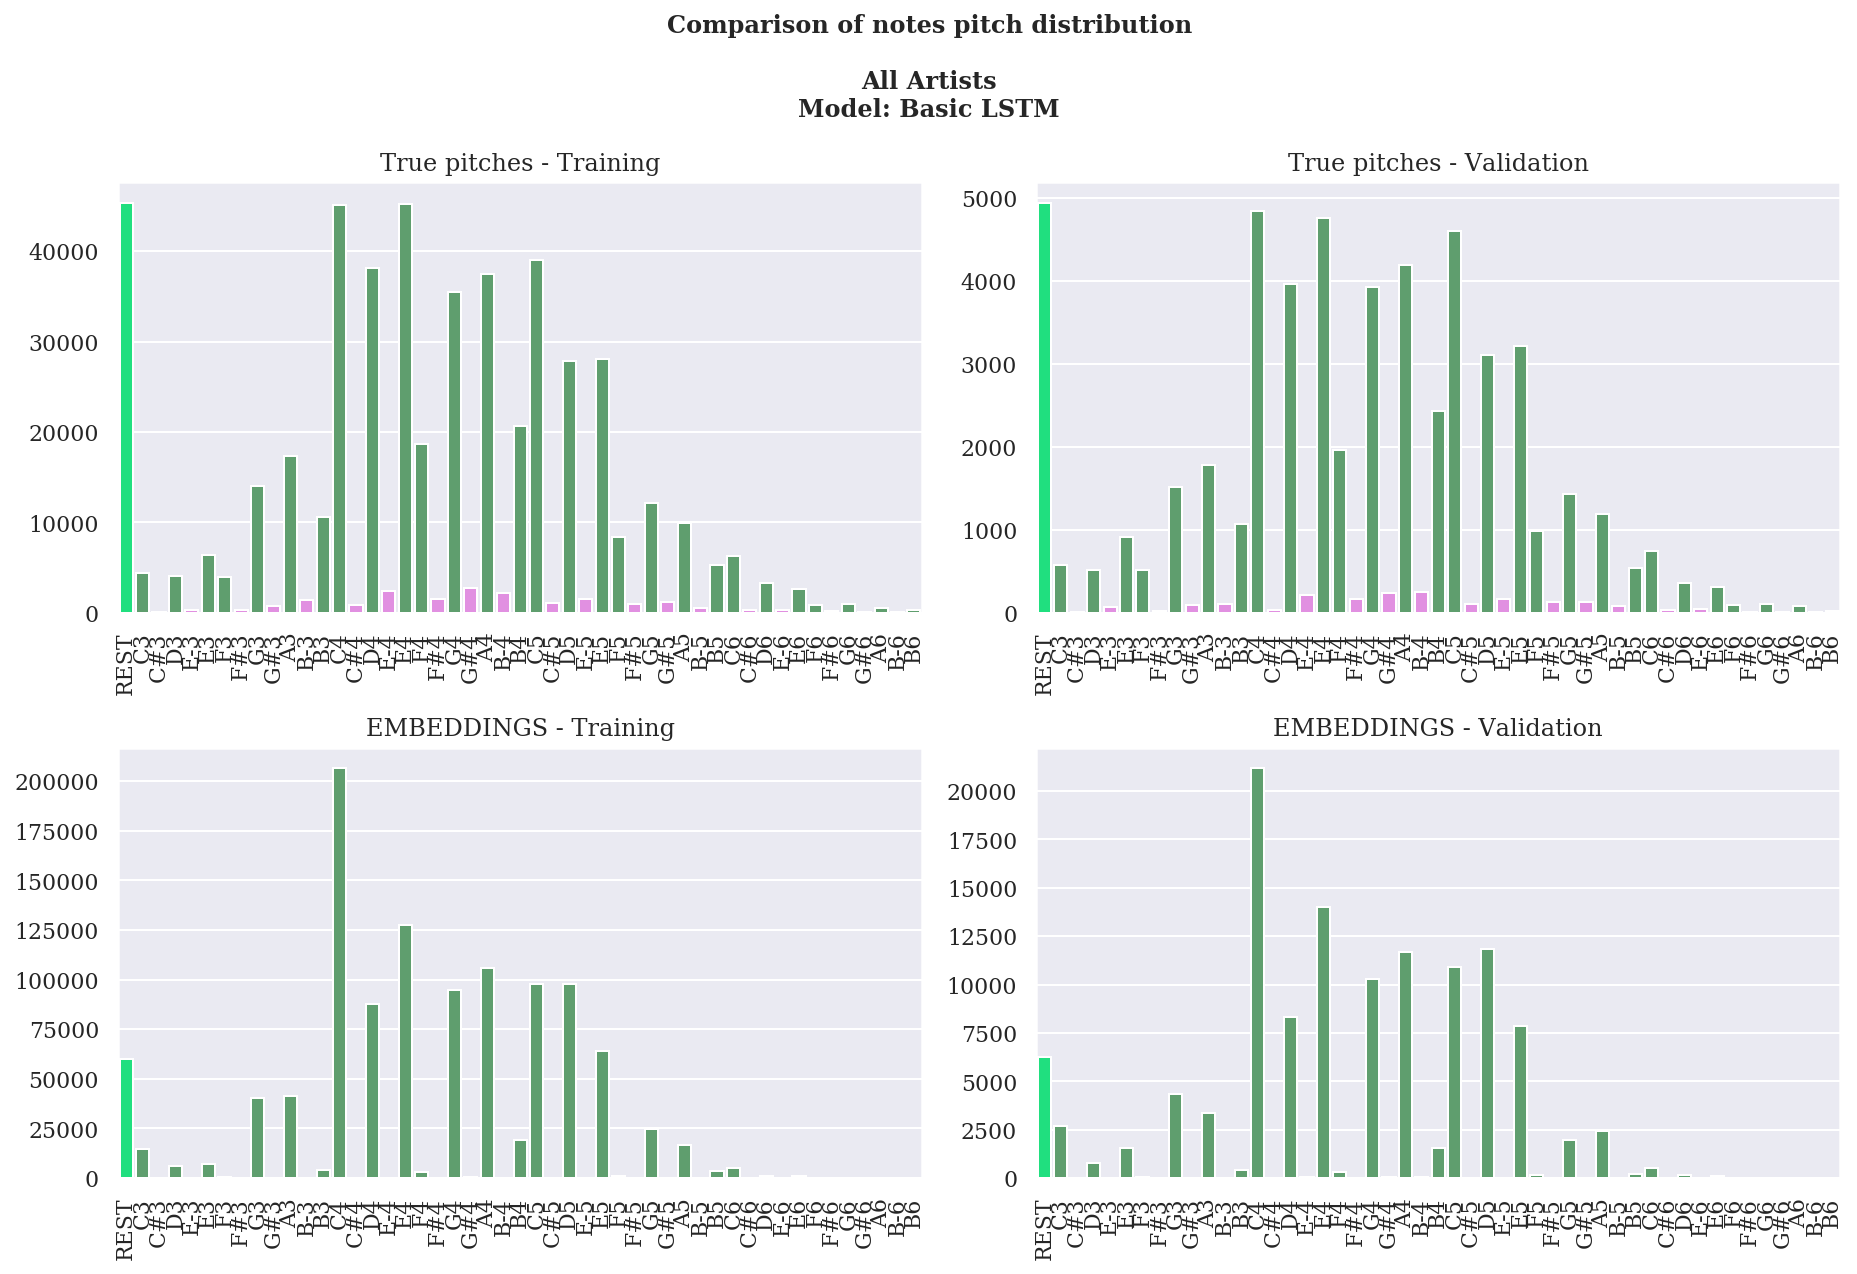

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(13, 8))

plot_pitches_distribution(axs[0, 0], y_p_train, all_notes=ALL_NOTES, with_octave=True)
axs[0, 0].set_title("True pitches - Training")
plot_pitches_distribution(axs[0, 1], y_p_val, all_notes=ALL_NOTES, with_octave=True)
axs[0, 1].set_title("True pitches - Validation")

j=1
# mode = "embeddings"
model_dir = f"LSTM-512_{ARTIST}" # f"LSTM-128_{ARTIST}"
# for model_dir in [f"LSTM-128_{ARTIST}", f"LSTM-NEW-128-128_{ARTIST}"]:
for mode in ["embeddings"]: #["pitches", "embeddings"]:
    i = 0
    for wh in which_d:
        predictions_dir = os.path.join(PATH, "models", mode, model_dir, "predictions")
        pred_notes, _ = read_predictions(predictions_dir, which=wh)
        print(wh, len(pred_notes))

        pred_notes_flat = [nt for note in pred_notes for nt in note]
        pred_notes_flat_pitch = [nt.split('_')[0] for nt in pred_notes_flat]
        plot_pitches_distribution(axs[j, i], pred_notes_flat_pitch, all_notes=ALL_NOTES,  with_octave=True)

        ttl = "Basic LSTM - " if "LSTM-NEW" not in model_dir else "Stacked LSTM - "
        axs[j, i].set_title(mode.upper() + " - " + which_d[wh])
        i += 1
    j += 1

fig.tight_layout()
if 'NEW' in model_dir:
    fig.suptitle(f"Comparison of notes pitch distribution\n\nAll Artists\nModel: Stacked LSTM", y=1.1, fontweight='bold')
else:
    fig.suptitle(f"Comparison of notes pitch distribution\n\nAll Artists\nModel: Basic LSTM", y=1.1, fontweight='bold')    

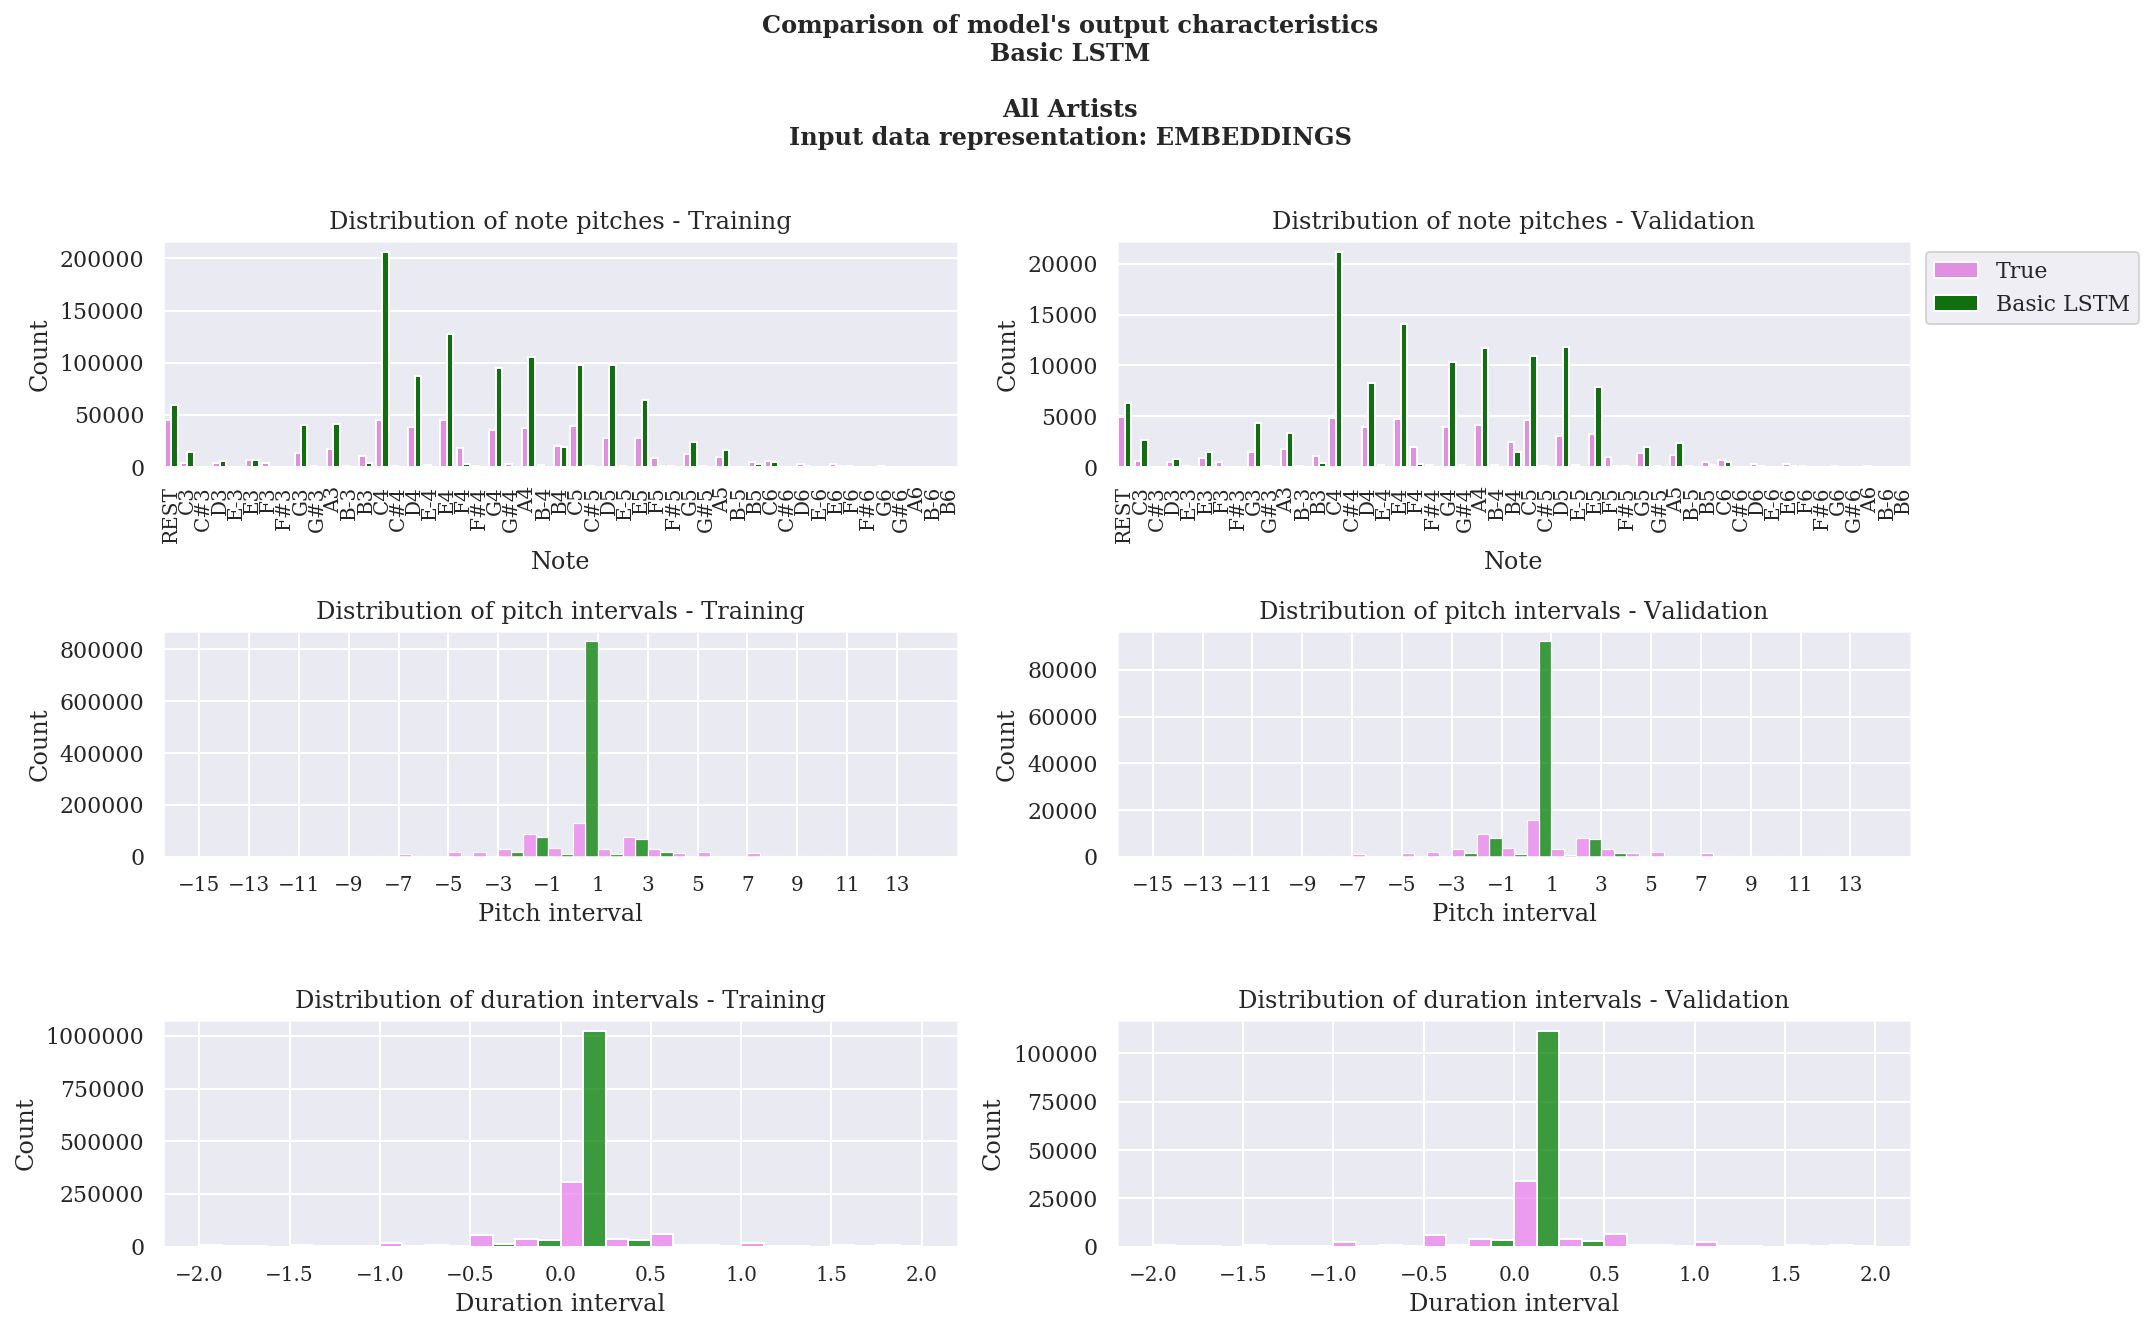

In [14]:
import matplotlib.ticker as ticker

def _get_notes_counts_sorted(notes, all_notes):
    notes_counts = Counter(notes).most_common()
    for n in all_notes:
        if n not in notes:
            notes_counts.append((n, 0))
    notes_counts_sorted = sorted(notes_counts, key=lambda x : _to_pitch(x[0], with_octave=True))
    assert len(notes_counts_sorted) == len(all_notes)
    return notes_counts_sorted

def _translate_type(typename):
    if "NEW" in typename:
        return "Stacked LSTM"
    elif "LSTM" in typename:
        return "Basic LSTM"
    else:
        return "True"
    
fig, axs = plt.subplots(3, 2, figsize=(15, 8))
WHICH = "train"

for col, WHICH in enumerate(["train", "val"]):
    x = []
    y = []
    types = []
    pitch_intervals_data = {"Pitch interval": [], "types": []}
    duration_intervals_data = {"Duration interval": [], "types": []}

    notes_counts_sorted = _get_notes_counts_sorted(y_p_train if WHICH == "train" else y_p_val, ALL_NOTES_sorted)
    x.extend([pair[0] for pair in notes_counts_sorted])
    y.extend([pair[1] for pair in notes_counts_sorted])
    types.extend([_translate_type("")] * len(ALL_NOTES_sorted))

    intervals = [x for xs in _get_intervals(notes_translated_train if WHICH == "train" else notes_translated_val) for x in xs]
    pitch_intervals_data["Pitch interval"].extend(intervals)
    pitch_intervals_data["types"].extend([_translate_type("")] * len(intervals))

    intervals = [x for xs in _get_duration_intervals(notes_translated_train if WHICH == "train" else notes_translated_val) for x in xs]
    duration_intervals_data["Duration interval"].extend(intervals)
    duration_intervals_data["types"].extend([_translate_type("")] * len(intervals))

    mode = "embeddings"
    for model_dir in [f"LSTM-512_{ARTIST}"]:
        predictions_dir = os.path.join(PATH, "models", mode, model_dir, "predictions")
        pred_notes, _ = read_predictions(predictions_dir, which=WHICH)
        pred_notes_flat = [nt for note in pred_notes for nt in note]
        pred_notes_flat_pitch = [nt.split('_')[0] for nt in pred_notes_flat]

        notes_counts_sorted = _get_notes_counts_sorted(pred_notes_flat_pitch, ALL_NOTES_sorted)

        x.extend([pair[0] for pair in notes_counts_sorted])
        y.extend([pair[1] for pair in notes_counts_sorted])
        types.extend([_translate_type(model_dir)] * len(ALL_NOTES_sorted))

        intervals = [x for xs in _get_intervals(pred_notes) for x in xs]
        pitch_intervals_data["Pitch interval"].extend(intervals)
        pitch_intervals_data["types"].extend([model_dir] * len(intervals))

        intervals = [x for xs in _get_duration_intervals(pred_notes) for x in xs]
        duration_intervals_data["Duration interval"].extend(intervals)
        duration_intervals_data["types"].extend([model_dir] * len(intervals))

    data = pd.DataFrame(
        {
            "Note": x, 
            "Count": y,
            "architecture": types
        }
    )

    colors = ["violet", "green"]
    chart = sns.barplot(x="Note", y="Count", hue="architecture", data=data, palette=colors, ax=axs[0, col])
    _ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='center')
    axs[0, col].set_title(f"Distribution of note pitches - {'Training' if WHICH == 'train' else 'Validation'}")
    axs[0, col].tick_params(axis='x', labelsize=10)

    bs_p = [i for i in range(-15, 15, 1)]
    chart = sns.histplot(data=pd.DataFrame(pitch_intervals_data), 
                 x="Pitch interval", 
                 hue="types", 
                 ax=axs[1, col], 
                 palette=colors, 
    #              element="step",
                 multiple="dodge",
                 bins=bs_p,
                 common_norm=True
                )
    axs[1, col].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[1, col].set_xticks(bs_p[::2])
    axs[1, col].set_title(f"Distribution of pitch intervals - {'Training' if WHICH == 'train' else 'Validation'}")
    axs[1, col].tick_params(axis='x', labelsize=10)


    bs = [i/4 for i in range(-8, 9, 1)]
    chart = sns.histplot(data=pd.DataFrame(duration_intervals_data), 
                 x="Duration interval", 
                 hue="types", 
                 ax=axs[2, col], 
                 palette=colors, 
                 multiple="dodge",
    #              element="step",
                 common_norm=True,
                 bins=bs
                )
    axs[2, col].xaxis.set_major_locator(ticker.MultipleLocator(0.25))
    axs[2, col].set_xticks(bs[::2])
    axs[2, col].set_title(f"Distribution of duration intervals - {'Training' if WHICH == 'train' else 'Validation'}")
    axs[2, col].tick_params(axis='x', labelsize=10)

    
    for idx in range(3):
        if idx == 0 and col == 1:
            axs[idx, col].legend(bbox_to_anchor=(1.3, 1))
        else:
            axs[idx, col].legend([],[], frameon=False)    
    
fig.suptitle(f"Comparison of model's output characteristics\nBasic LSTM\n\nAll Artists\nInput data representation: EMBEDDINGS", y=1.15, fontweight='bold')
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


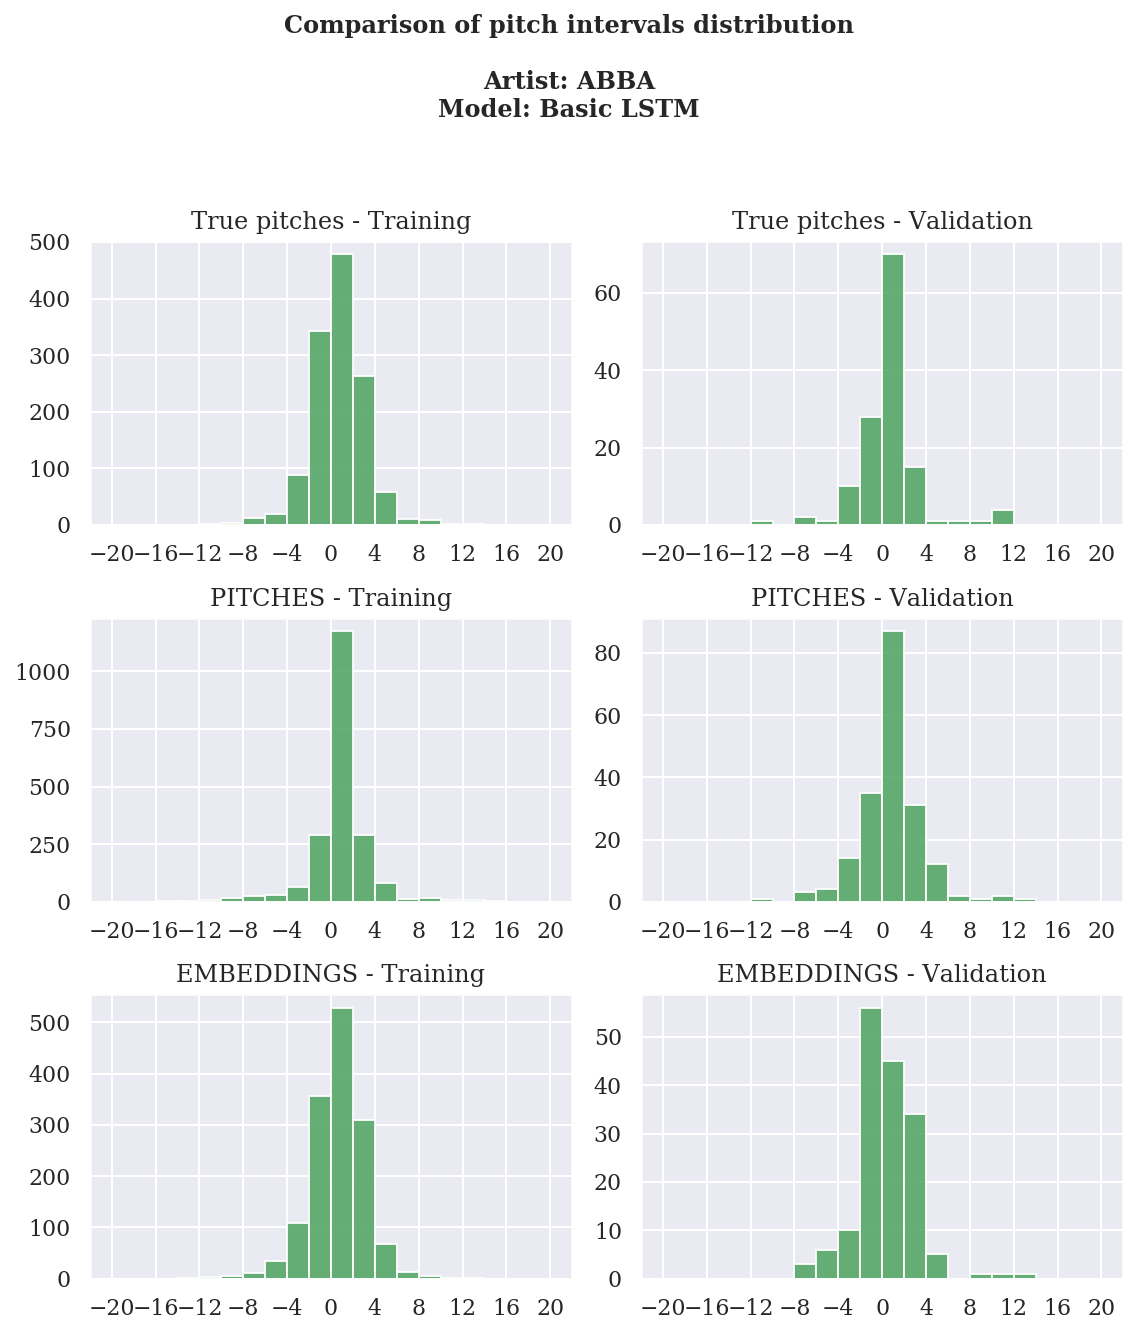

In [50]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

plot_pitches_intervals(axs[0, 0], notes_translated_train)
axs[0, 0].set_title("True pitches - Training")
plot_pitches_intervals(axs[0, 1], notes_translated_val)
axs[0, 1].set_title("True pitches - Validation")

j=1
for mode in ["pitches", "embeddings"]:
    i = 0
    for wh in which_d:
        predictions_dir = os.path.join(PATH, "models", mode, model_dir, "predictions")
        pred_notes, _ = read_predictions(predictions_dir, which=wh)
        plot_pitches_intervals(axs[j, i], pred_notes)
        axs[j, i].set_title(mode.upper() + " - " + which_d[wh])
        i += 1
    j += 1

fig.tight_layout()
if 'NEW' in model_dir:
    fig.suptitle(f"Comparison of pitch intervals distribution\n\nArtist: {ARTIST.upper()}\nModel: Stacked LSTM", y=1.15, fontweight='bold')
else:
    fig.suptitle(f"Comparison of pitch intervals distribution\n\nArtist: {ARTIST.upper()}\nModel: Basic LSTM", y=1.15, fontweight='bold')


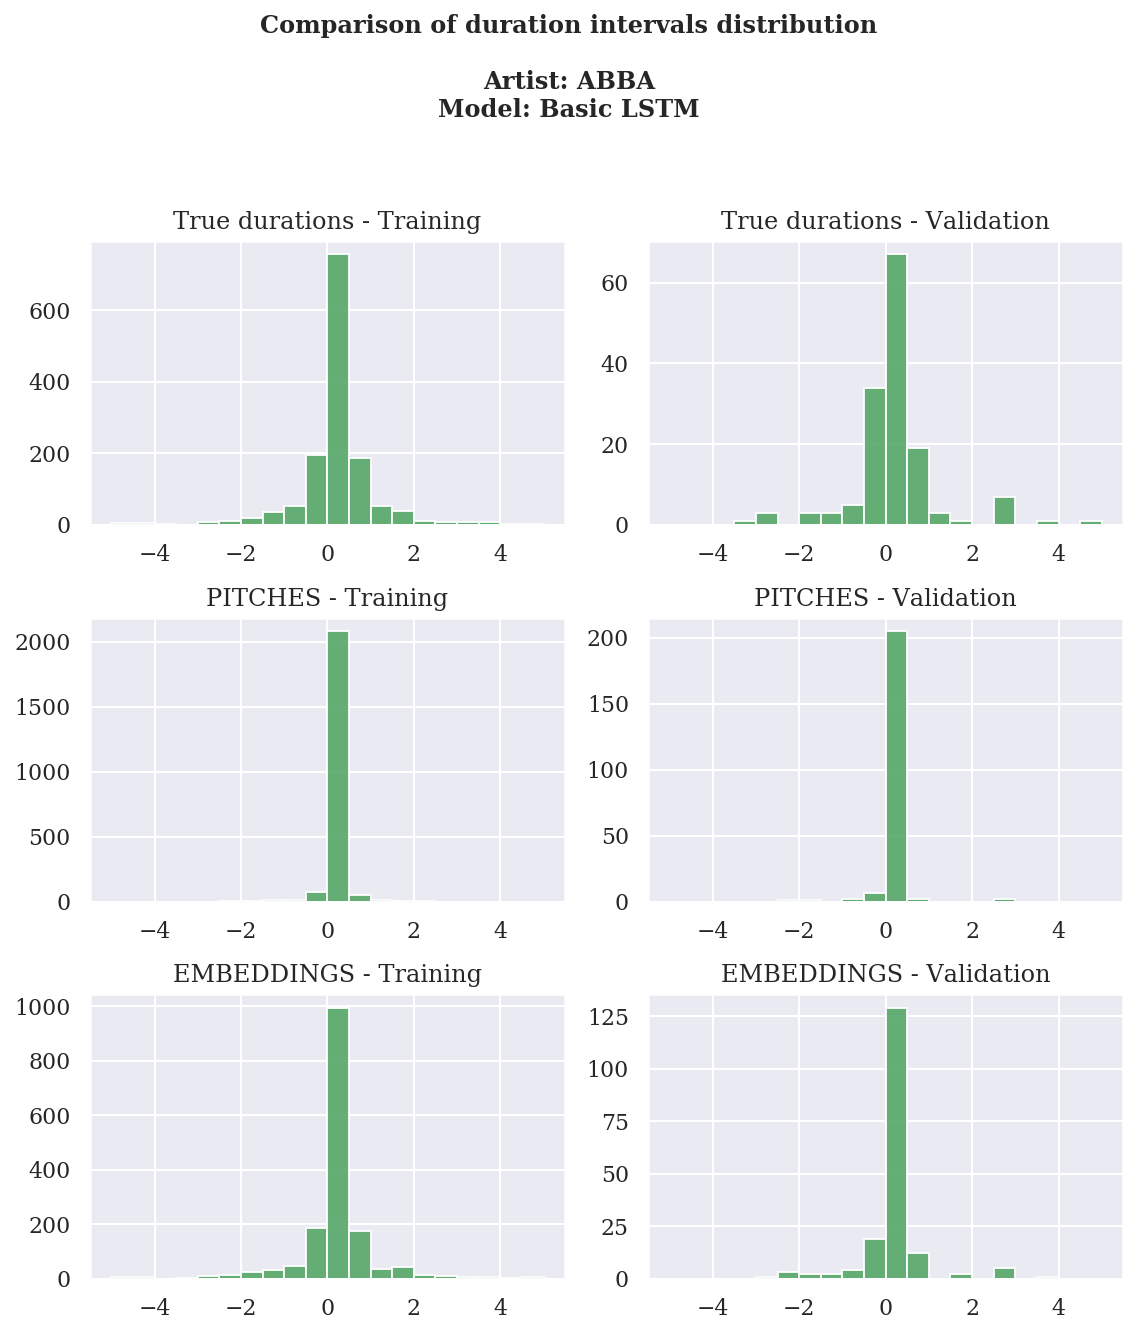

In [51]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

plot_durations_intervals(axs[0, 0], [notes for idx, notes in enumerate(notes_translated) if idx in train_idx_list])
axs[0, 0].set_title("True durations - Training")
plot_durations_intervals(axs[0, 1], [notes for idx, notes in enumerate(notes_translated) if idx in validation_idx_list])
axs[0, 1].set_title("True durations - Validation")

j=1
for mode in ["pitches", "embeddings"]:
    i = 0
    for wh in which_d:
        predictions_dir = os.path.join(PATH, "models", mode, model_dir, "predictions")
        pred_notes, _ = read_predictions(predictions_dir, which=wh)
        plot_durations_intervals(axs[j, i], pred_notes)
        axs[j, i].set_title(mode.upper() + " - " + which_d[wh])
        i += 1
    j += 1

fig.tight_layout()
if 'NEW' in model_dir:
    fig.suptitle(f"Comparison of duration intervals distribution\n\nArtist: {ARTIST.upper()}\nModel: Stacked LSTM", y=1.15, fontweight='bold')
else:
    fig.suptitle(f"Comparison of duration intervals distribution\n\nArtist: {ARTIST.upper()}\nModel: Basic LSTM", y=1.15, fontweight='bold')


In [15]:
def get_chord_to_notes(songs, chords, translate=False):
    chord_to_notes = {}
    for sample_notes, sample_chords in zip(songs, chords):

        sample_notes_flat, sample_chords_flat = [], []
        for sn in sample_notes:
            counter = int(float(sn.split('_')[1]) / MIN_D)
            if translate:
                value = float(sn.split('_')[0])
                sn_translated = mc.note.Note(value).nameWithOctave if value != -1.0 else "REST"
                sample_notes_flat.extend([sn_translated] * counter)
            else:    
                sample_notes_flat.extend([sn.split('_')[0]] * counter)
        for sch in sample_chords:
            counter = int(float(sch.split('_')[1]) / MIN_D)
            sample_chords_flat.extend([sch.split('_')[0]] * counter)

        if len(sample_notes_flat) < len(sample_chords_flat):
            sample_notes_flat.extend(['REST'] * (len(sample_chords_flat) - len(sample_notes_flat)))
        elif len(sample_notes_flat) > len(sample_chords_flat):
            sample_chords_flat.extend(['REST'] * (len(sample_notes_flat) - len(sample_chords_flat)))

        assert len(sample_notes_flat) == len(sample_chords_flat)

        for n, ch in zip(sample_notes_flat, sample_chords_flat):
            if ch not in chord_to_notes:
                chord_to_notes[ch] = [0] * len(ALL_NOTES_no_octave)
            else:
                try:
                    select = note_to_idx[n[:-1]] if n != "REST" else note_to_idx[n]
                    chord_to_notes[ch][select] += 1
                except Exception as ex:
                    print(ex)
    return chord_to_notes


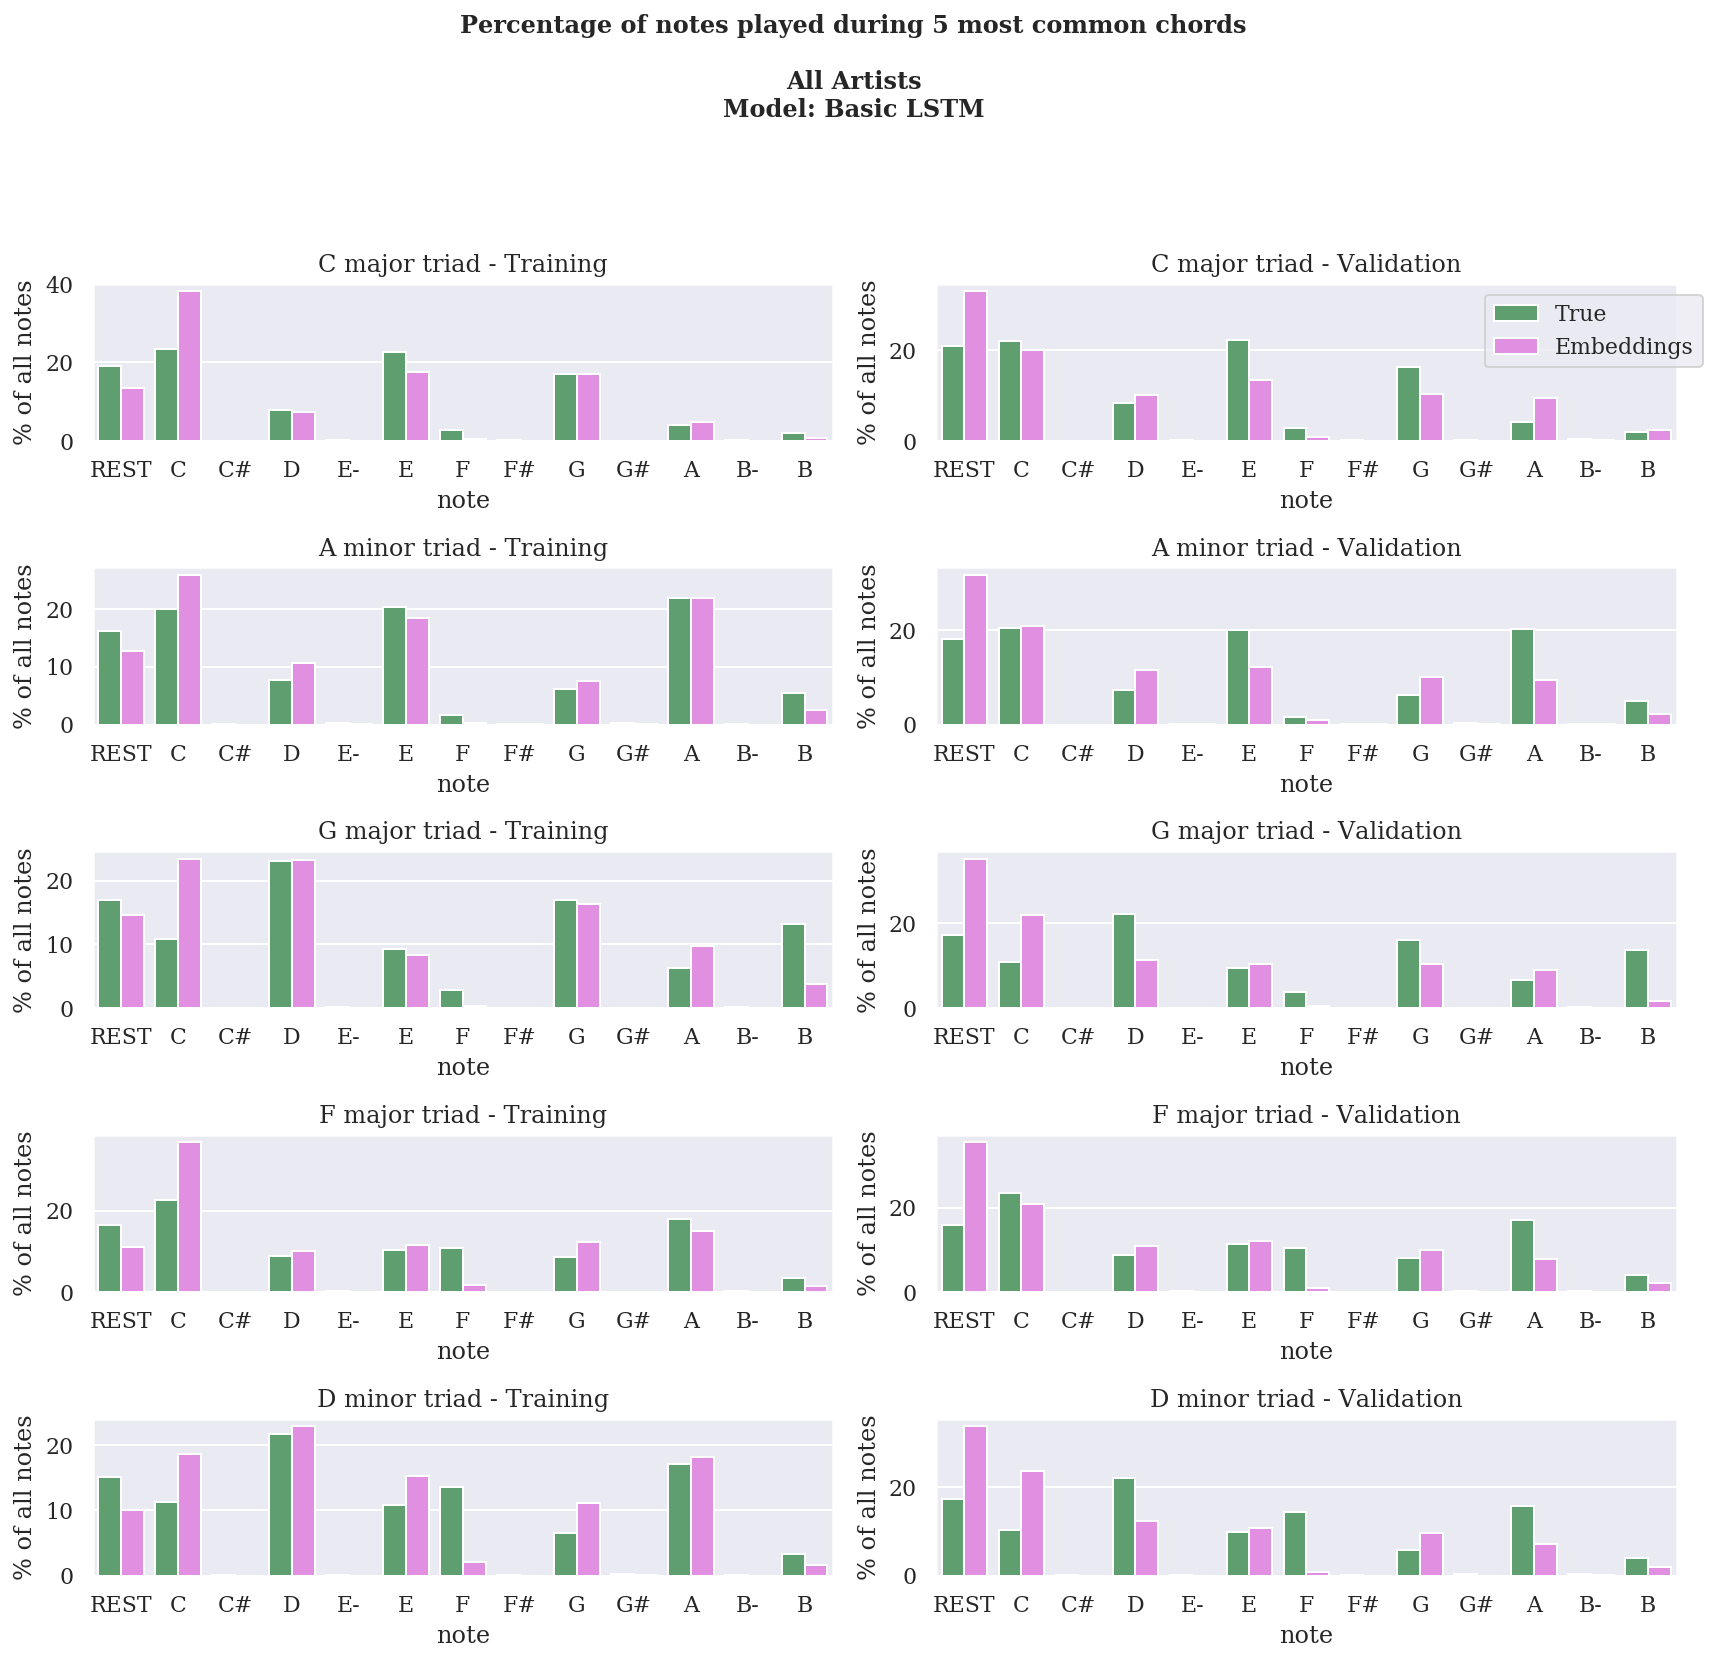

In [27]:
import pandas as pd

N_MOST_COMMON = 5
SELECT = "train"
CHORDS = chords_translated_train
NOTES = notes_translated_train
model_dir = f"LSTM-512_{ARTIST}"

flat_chords = [ch.split('_')[0] for chords in CHORDS for ch in chords]
fig, axs = plt.subplots(N_MOST_COMMON, 2, figsize=(12, 10))

for col, (CHORDS, NOTES, typename) in enumerate(
    [
        (chords_translated_train, notes_translated_train, "train"), 
        (chords_translated_val, notes_translated_val, "val")
    ]
):
    chord_to_notes_true = get_chord_to_notes(NOTES, CHORDS, translate=True)
    for idx, (chord, _) in enumerate(Counter(flat_chords).most_common(N_MOST_COMMON)):
        vec = []
        x = ALL_NOTES_no_octave.copy()
        types = []

        vec_true = np.array(chord_to_notes_true[chord])
        vec_true = (vec_true / np.sum(vec_true) * 100.0).tolist()
        vec.extend(vec_true)
        types.extend(["True"] * len(vec_true))

        for mode in ['Embeddings']:
            x += ALL_NOTES_no_octave

            predictions_dir = os.path.join(PATH, "models", mode.lower(), model_dir, "predictions")
            pred_notes, ids = read_predictions(predictions_dir)
            pred_select_songs = [p_notes for p_notes, identifier in zip(pred_notes, ids) if SELECT in identifier]
            chord_to_notes_pred = get_chord_to_notes(pred_select_songs, CHORDS)

            vec_pred = np.array(chord_to_notes_pred[chord])
            vec_pred = (vec_pred / np.sum(vec_pred) * 100.0).tolist()
            vec.extend(vec_pred)
            types.extend([mode] * len(vec_pred))

        data = pd.DataFrame(
            {
                "note": x, 
                "% of all notes": vec,
                "type": types
            }
        )
        colors = ["g", "violet"]#, "yellow"]
        sns.barplot(x="note", y="% of all notes", hue="type", data=data, palette=colors, ax=axs[idx, col])
        if idx == 0 and col == 1:
            axs[idx, col].legend(bbox_to_anchor=(1.05, 1))
        else:
            axs[idx, col].legend([],[], frameon=False)
        axs[idx, col].set_title(chord + " - " + ("Training" if typename == "train" else "Validation"))

if 'NEW' in model_dir:
    fig.suptitle(f"Percentage of notes played during {N_MOST_COMMON} most common chords\n\nArtist: {ARTIST.upper()}\nModel: Stacked LSTM", y=1.15, fontweight='bold')
else:
    fig.suptitle(f"Percentage of notes played during {N_MOST_COMMON} most common chords\n\nAll Artists\nModel: Basic LSTM", y=1.15, fontweight='bold')
fig.tight_layout()

In [29]:
chord_to_notes_true = get_chord_to_notes(notes_translated, chords_translated, translate=True)

for mode in ["embeddings"]:
    print(mode)
    for model_dir in [f"LSTM-512_{ARTIST}"]:
        print(model_dir)
        for NOTES, CHORDS, SELECT in [(notes_translated_train, chords_translated_train, "train"), (notes_translated_val, chords_translated_val, "val")]:
            print()
            print(SELECT)
            # chord_to_notes_true = get_chord_to_notes(NOTES, CHORDS, translate=True)
            flat_chords = [ch.split('_')[0] for chords in CHORDS for ch in chords]

            predictions_dir = os.path.join(PATH, "models", mode, model_dir, "predictions")
            pred_notes, ids = read_predictions(predictions_dir)
            pred_select_songs = [p_notes for p_notes, identifier in zip(pred_notes, ids) if SELECT in identifier]
            chord_to_notes_pred = get_chord_to_notes(pred_select_songs, CHORDS)

            n = 0
            n_unweighted = 0
            acc, acc_unweighted = 0, 0

            for chord, count in Counter(flat_chords).most_common(N_MOST_COMMON):
                v2 = np.array(chord_to_notes_pred[chord])
                if chord in chord_to_notes_true:
                    v1 = np.array(chord_to_notes_true[chord])
                else:
                    v1 = v2.copy()
                v1 = v1 / np.sum(v1)
                v2 = v2 / np.sum(v2)
                mse = np.sum((v1 - v2)**2)

                n += count
                acc += (mse * count)

                acc_unweighted += mse
                n_unweighted += 1

            print(round(acc / n, 4), "&", round(acc_unweighted / n_unweighted, 4))
#             print("weighted:", round(acc / n, 4)) # macro?
#             print("unweighted:", round(acc_unweighted / n_unweighted, 4)) # micro?

embeddings
LSTM-512_*

train
0.0246 & 0.025

val
0.0227 & 0.0229


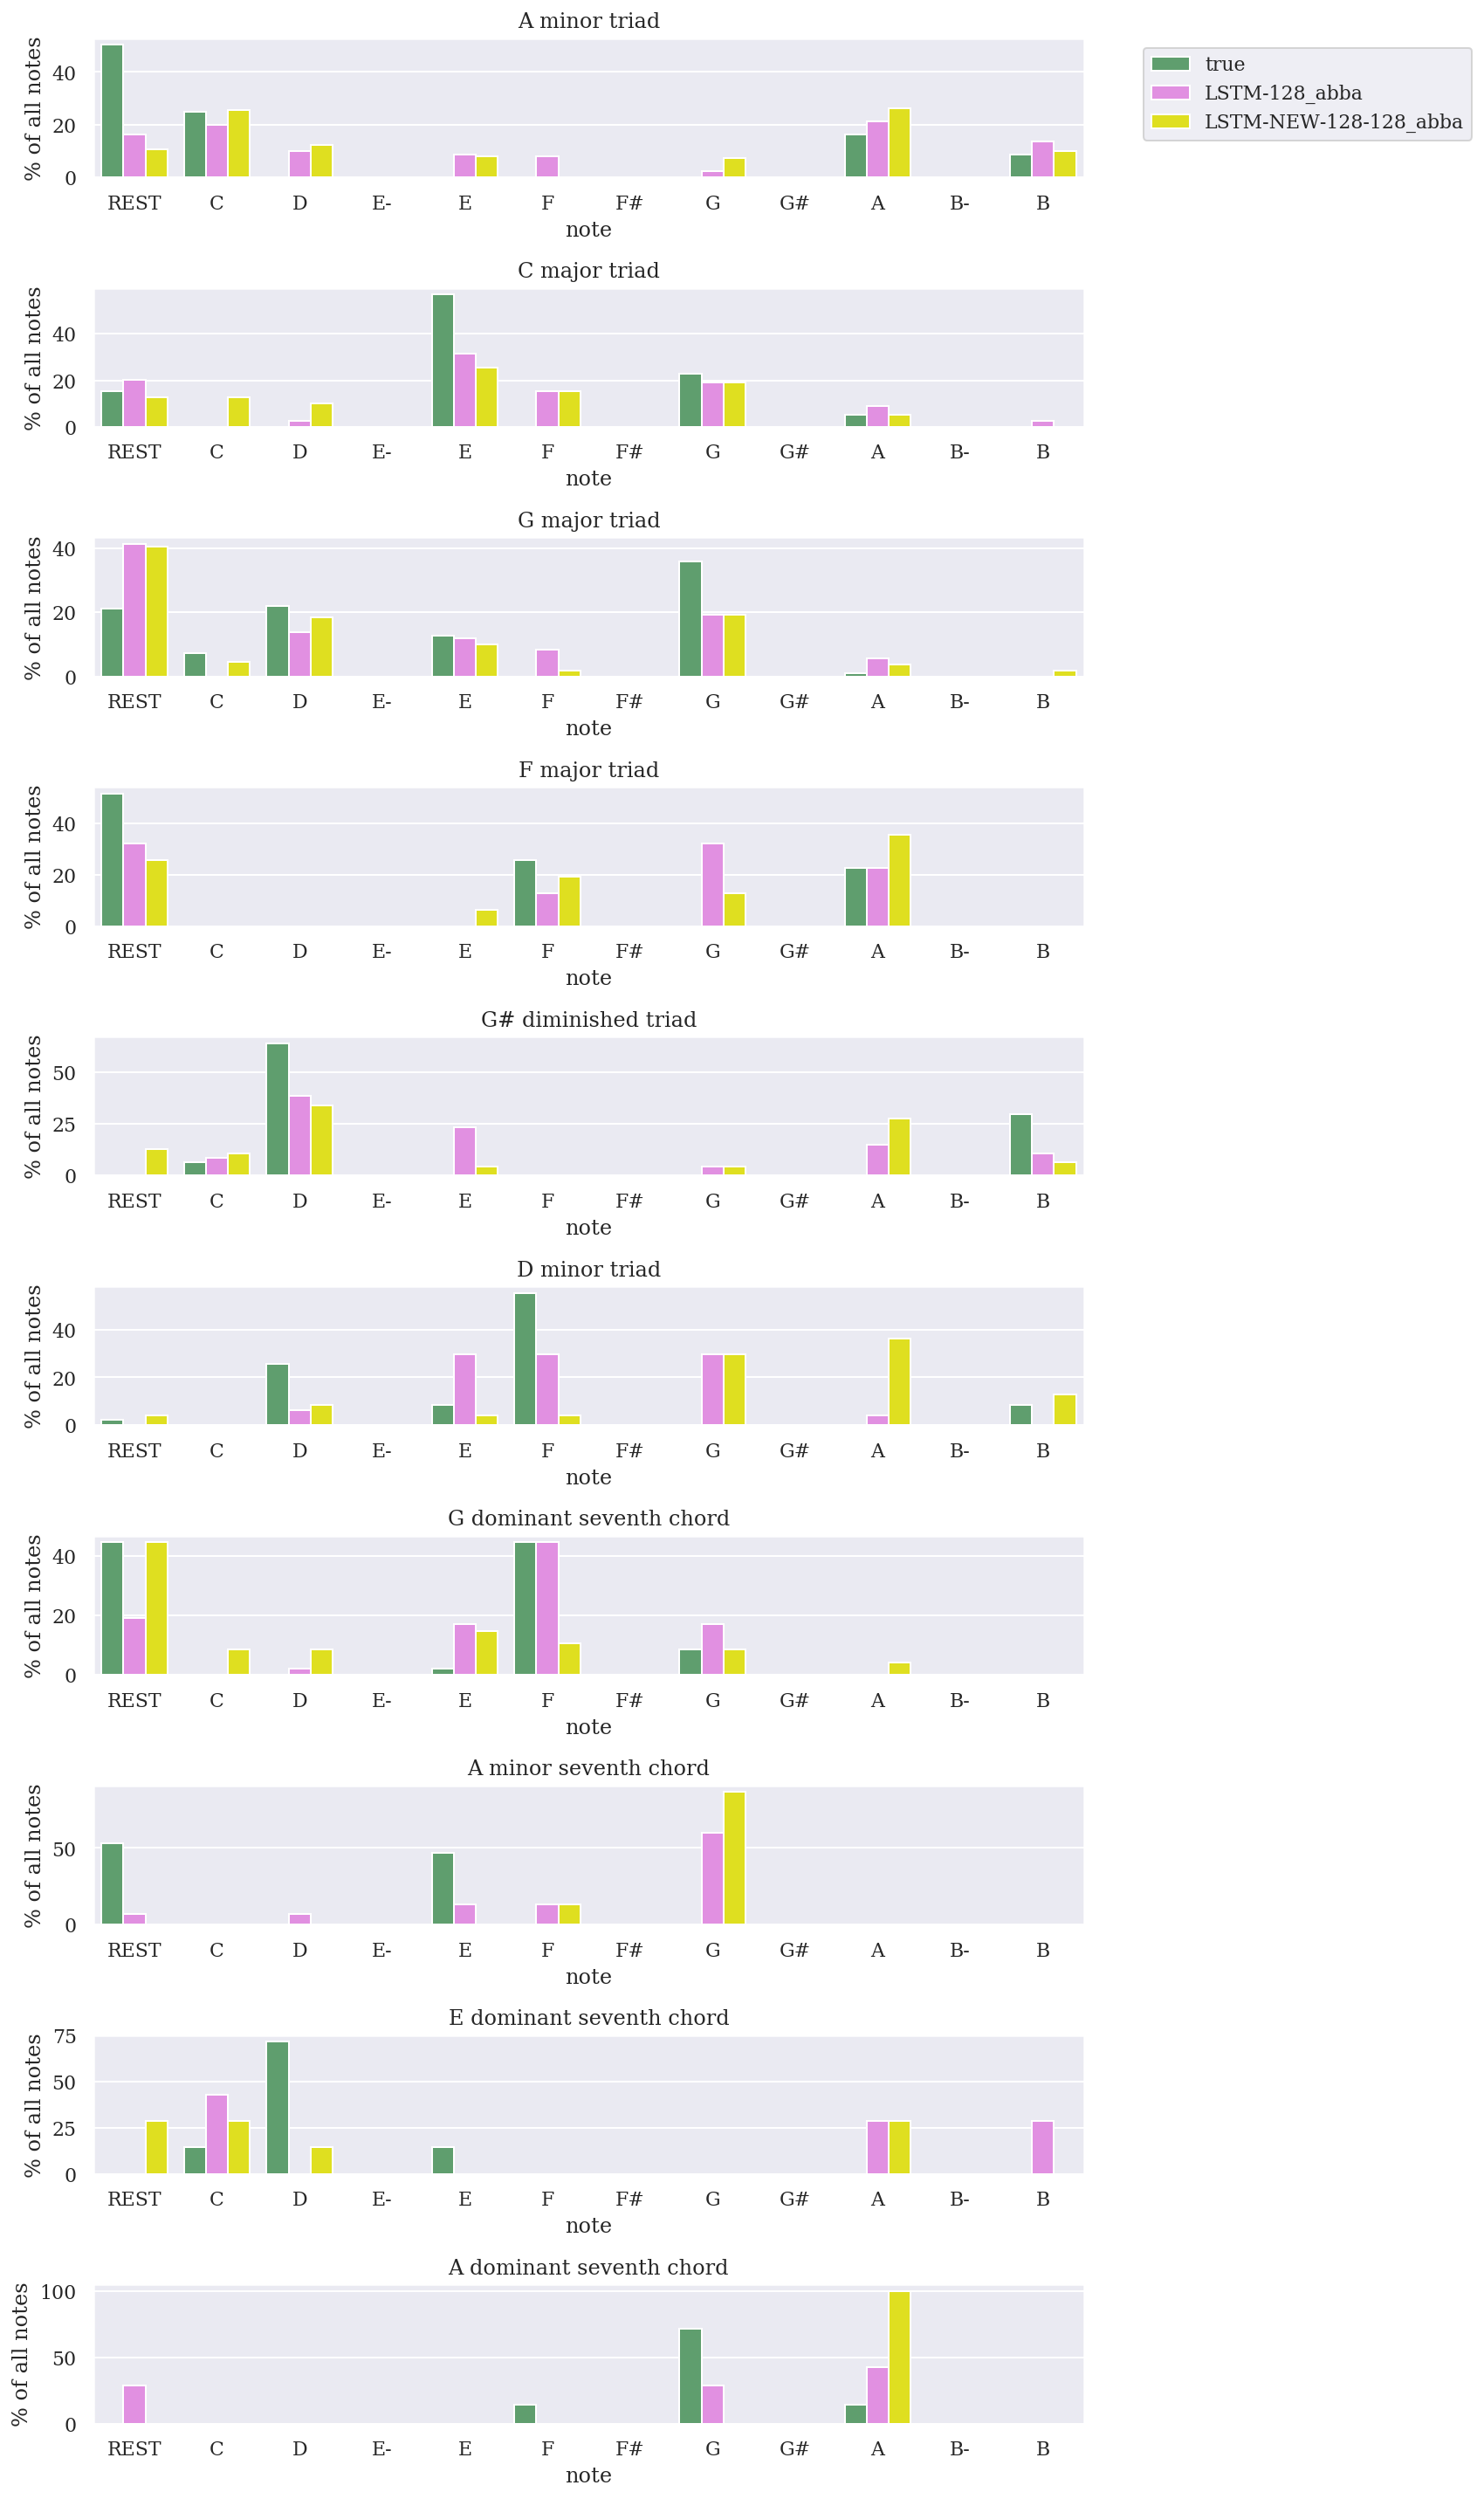

In [55]:
N_MOST_COMMON = 10
SELECT = "val"
CHORDS = chords_translated_val
NOTES = notes_translated_val

mode = "embeddings"
flat_chords = [ch.split('_')[0] for chords in CHORDS for ch in chords]
fig, axs = plt.subplots(N_MOST_COMMON, 1, figsize=(12, 2*N_MOST_COMMON))

chord_to_notes_true = get_chord_to_notes(NOTES, CHORDS, translate=True)
for idx, (chord, _) in enumerate(Counter(flat_chords).most_common(N_MOST_COMMON)):
    vec = []
    x = ALL_NOTES_no_octave.copy()
    types = []
    
    vec_true = np.array(chord_to_notes_true[chord])
    vec_true = (vec_true / np.sum(vec_true) * 100.0).tolist()
    vec.extend(vec_true)
    types.extend(["true"] * len(vec_true))
    
    for model_dir in [f"LSTM-128_{ARTIST}", f"LSTM-NEW-128-128_{ARTIST}"]:
        x += ALL_NOTES_no_octave
        
        predictions_dir = os.path.join(PATH, "models", mode, model_dir, "predictions")
        pred_notes, ids = read_predictions(predictions_dir, which=SELECT)
        pred_select_songs = [p_notes for p_notes, identifier in zip(pred_notes, ids) if SELECT in identifier]
        chord_to_notes_pred = get_chord_to_notes(pred_select_songs, CHORDS)
        
        vec_pred = np.array(chord_to_notes_pred[chord])
        vec_pred = (vec_pred / np.sum(vec_pred) * 100.0).tolist()
        vec.extend(vec_pred)
        types.extend([model_dir] * len(vec_pred))

    data = pd.DataFrame(
        {
            "note": x, 
            "% of all notes": vec,
            "type": types
        }
    )
    colors = ["g", "violet", "yellow"]
    sns.barplot(x="note", y="% of all notes", hue="type", data=data, palette=colors, ax=axs[idx])
    if idx == 0:
        axs[idx].legend(bbox_to_anchor=(1.05, 1))
    else:
        axs[idx].legend([],[], frameon=False)
    axs[idx].set_title(chord)

# if 'NEW' in model_dir:
#     fig.suptitle(f"Percentage of notes played during {N_MOST_COMMON} most common chords\n\nArtist: {ARTIST.upper()}\nValidation\nModel: Stacked LSTM", y=1.15, fontweight='bold')
# else:
#     fig.suptitle(f"Percentage of notes played during {N_MOST_COMMON} most common chords\n\nArtist: {ARTIST.upper()}\nValidation\nModel: Basic LSTM", y=1.15, fontweight='bold')
fig.tight_layout()

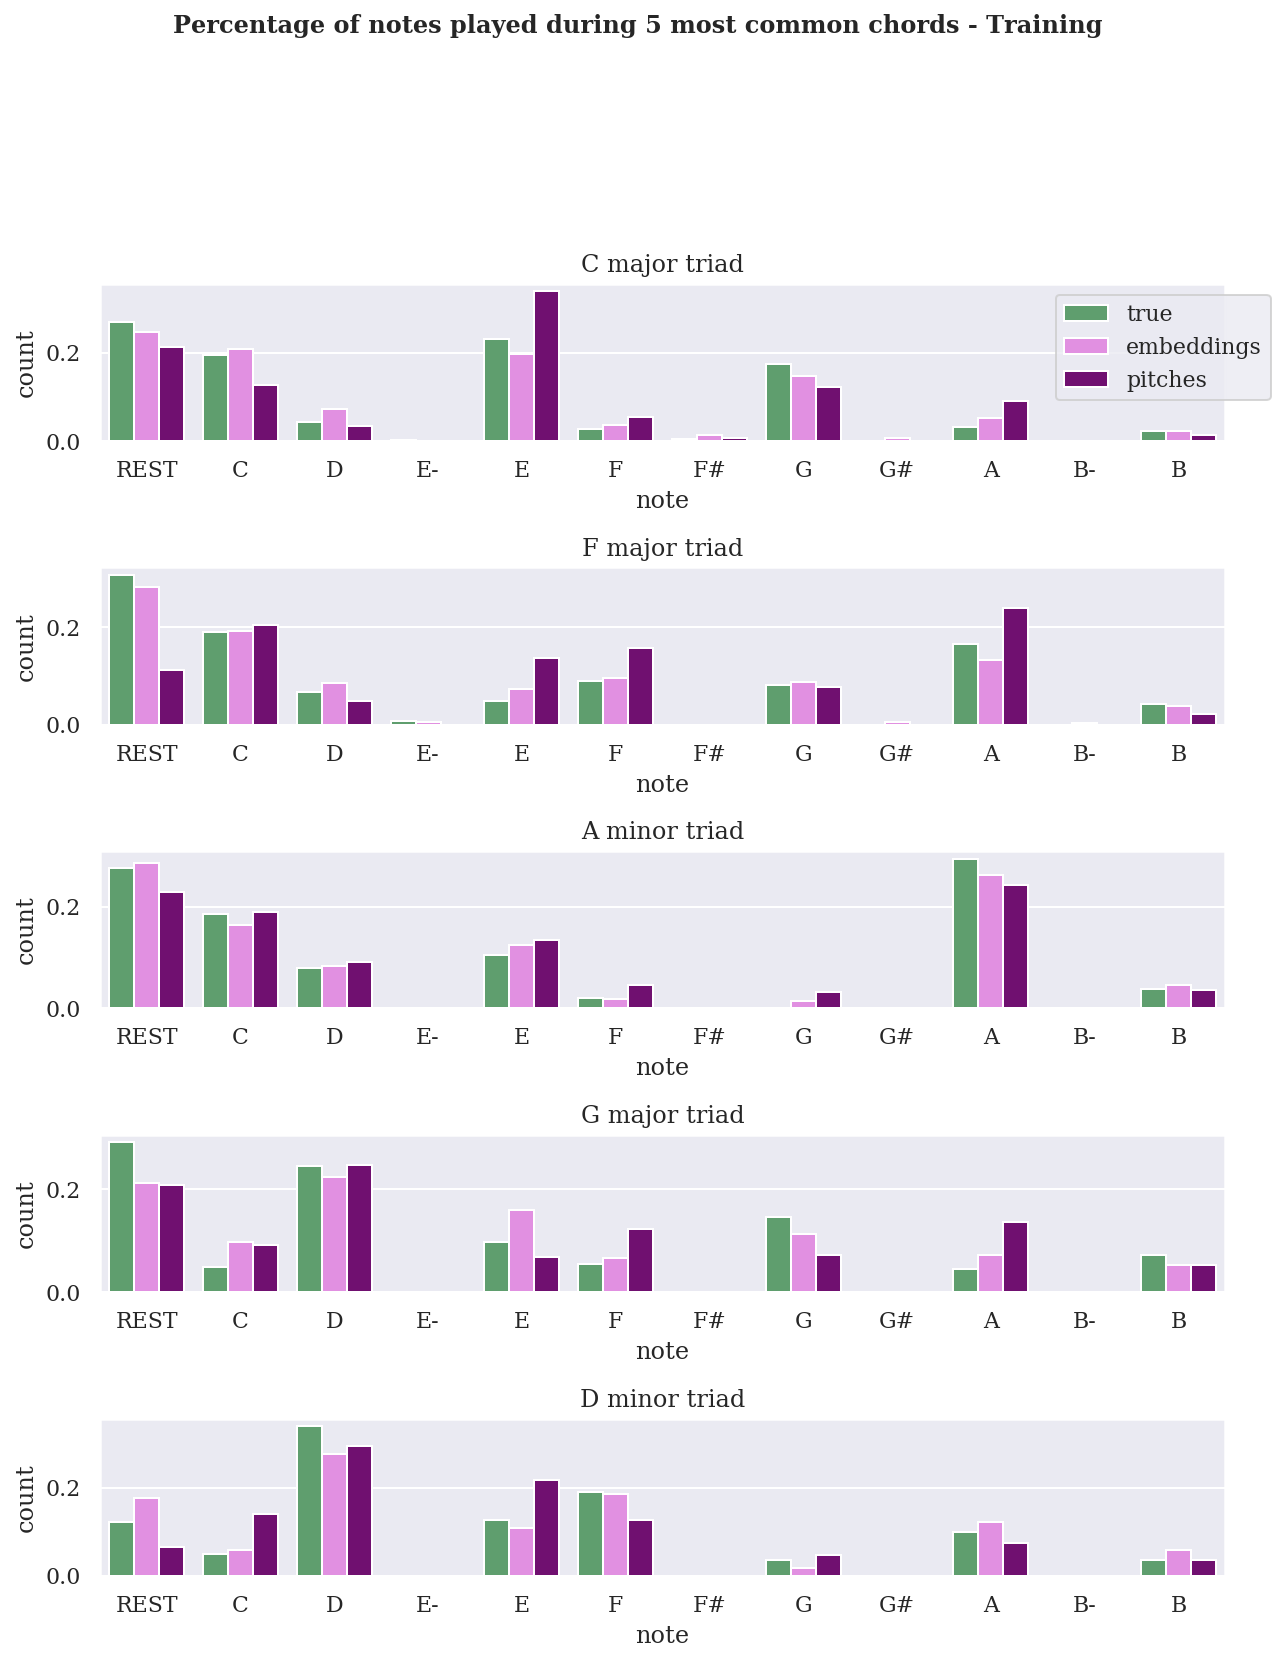

In [56]:
flat_chords_train = [ch.split('_')[0] for chords in chords_translated_train for ch in chords]

N_MOST_COMMON = 5
SELECT = "train"
fig, axs = plt.subplots(N_MOST_COMMON, 1, figsize=(9, 10))

CHORDS = chords_translated_train
chord_to_notes_true = get_chord_to_notes(notes_translated_train, CHORDS, translate=True)
for idx, (chord, _) in enumerate(Counter(flat_chords_train).most_common(N_MOST_COMMON)):
    vec = []
    x = ALL_NOTES_no_octave.copy()
    types = []
    
    vec_true = np.array(chord_to_notes_true[chord])
    vec_true = (vec_true / np.sum(vec_true)).tolist()
    vec.extend(vec_true)
    types.extend(["true"] * len(vec_true))
    
    for mode in ['embeddings', 'pitches']:
        x += ALL_NOTES_no_octave
        
        predictions_dir = os.path.join(PATH, "models", mode, model_dir, "predictions")
        pred_notes, ids = read_predictions(predictions_dir)
        pred_select_songs = [p_notes for p_notes, identifier in zip(pred_notes, ids) if SELECT in identifier]
        chord_to_notes_pred = get_chord_to_notes(pred_select_songs, CHORDS)
        
        vec_pred = np.array(chord_to_notes_pred[chord])
        vec_pred = (vec_pred / np.sum(vec_pred)).tolist()
        vec.extend(vec_pred)
        types.extend([mode] * len(vec_pred))

    data = pd.DataFrame(
        {
            "note": x, 
            "count": vec,
            "type": types
        }
    )
    colors = ["g", "violet", "purple"]
    sns.barplot(x="note", y="count", hue="type", data=data, palette=colors, ax=axs[idx])
    if idx == 0:
        axs[idx].legend(bbox_to_anchor=(1.05, 1))
    else:
        axs[idx].legend([],[], frameon=False)
    axs[idx].set_title(chord)

fig.suptitle(f"Percentage of notes played during {N_MOST_COMMON} most common chords - Training", y=1.15, fontweight='bold')
fig.tight_layout()